# Parameter inference

Which parameters of the telegraph model explain the best the observed data?

Rather than trying parameters by hand, we can use mathematical methods from parameter inference to find the best parameters.

Rather than performing time-consuming simulation, we can derive a formula for the probability distribution of the telegraph model:

The probability to find $x$ number of RNA molecules in a cell is given by:

$\begin{equation}
P(\text{number of RNA molecules} = x) \sim NegativeBinomial(x, ...)
\end{equation}$

In [1]:
import numpy as np
from scipy import stats
from numpy import mean
from numpy.random import beta, poisson
from scipy.special import j_roots
from scipy.special import beta as beta_fun
from matplotlib import pyplot as plt
import pandas as pd

In [4]:
maternal_allele = pd.read_csv('../data/SS3_c57_UMIs_concat.csv', index_col=0)
paternal_allele = pd.read_csv('../data/SS3_cast_UMIs_concat.csv', index_col=0)
total_data = maternal_allele + paternal_allele

In [6]:
total_data

,SS3_MAF_Leo171129_p2_S10,SS3_MAF_Leo171129_p2_S12,SS3_MAF_Leo171129_p2_S13,SS3_MAF_Leo171129_p2_S14,SS3_MAF_Leo171129_p2_S16,SS3_MAF_Leo171129_p2_S17,SS3_MAF_Leo171129_p2_S18,SS3_MAF_Leo171129_p2_S19,SS3_MAF_Leo171129_p2_S1,SS3_MAF_Leo171129_p2_S20,...,SS3_MAF_leo180223_p4_S182,SS3_MAF_leo180223_p4_S186,SS3_MAF_leo180223_p4_S187,SS3_MAF_leo180223_p4_S191,SS3_MAF_leo180223_p4_S185,SS3_MAF_leo180223_p4_S189,SS3_MAF_leo180223_p4_S188,SS3_MAF_leo180223_p4_S190,SS3_MAF_leo180223_p4_S98,SS3_MAF_leo180223_p4_S99
0610005C13Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0610007P14Rik,1.0,3.0,6.0,3.0,2.0,4.0,8.0,9.0,7.0,10.0,...,4.0,4.0,2.0,2.0,4.0,14.0,5.0,5.0,1.0,4.0
0610009B22Rik,10.0,4.0,NaN,NaN,2.0,23.0,26.0,8.0,9.0,5.0,...,12.0,5.0,2.0,3.0,21.0,2.0,1.0,4.0,3.0,8.0
0610009L18Rik,0.0,0.0,0.0,0.0,0.0,2.0,4.0,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
0610009O20Rik,3.0,0.0,0.0,2.0,0.0,2.0,1.0,2.0,3.0,0.0,...,4.0,1.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zyg11b,0.0,NaN,1.0,NaN,4.0,13.0,1.0,9.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,3.0,1.0,0.0,1.0,3.0
Zyx,7.0,24.0,36.0,25.0,30.0,63.0,68.0,28.0,55.0,16.0,...,15.0,24.0,5.0,9.0,37.0,21.0,30.0,57.0,33.0,6.0
Zzef1,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
Zzz3,1.0,1.0,2.0,2.0,2.0,1.0,2.0,9.0,0.0,7.0,...,2.0,7.0,0.0,0.0,4.0,6.0,0.0,0.0,7.0,2.0


In [12]:
def MomentInference(vals, export_moments=False):
    # code from Anton Larsson's R implementation
    from scipy import stats # needs imports inside function when run in ipyparallel
    import numpy as np
    m1 = float(np.mean(vals))
    m2 = float(sum(vals*(vals - 1))/len(vals))
    m3 = float(sum(vals*(vals - 1)*(vals - 2))/len(vals))
    
    # sanity check on input (e.g. need at least on expression level)
    if sum(vals) == 0: return np.nan
    if m1 == 0: return np.nan
    if m2 == 0: return np.nan
    
    r1=m1
    r2=m2/m1
    r3=m3/m2
    
    if (r1*r2-2*r1*r3 + r2*r3) == 0: return np.nan
    if ((r1*r2 - 2*r1*r3 + r2*r3)*(r1-2*r2+r3)) == 0: return np.nan
    if (r1 - 2*r2 + r3) == 0: return np.nan
        
    lambda_est = (2*r1*(r3-r2))/(r1*r2-2*r1*r3 + r2*r3)
    mu_est = (2*(r3-r2)*(r1-r3)*(r2-r1))/((r1*r2 - 2*r1*r3 + r2*r3)*(r1-2*r2+r3))
    v_est = (2*r1*r3 - r1*r2 - r2*r3)/(r1 - 2*r2 + r3)
    
    if export_moments:
        return np.array([lambda_est, mu_est, v_est, r1, r2, r3])
    
    return np.array([lambda_est, mu_est, v_est])

def MaximumLikelihood(vals, export_asymp_ci = False, fix = 0, export_fun = False):
    from scipy.interpolate import interp1d
    from scipy.optimize import minimize
    from scipy import special
    from scipy.stats import poisson,norm
    from scipy.special import j_roots
    from scipy.special import beta as beta_fun    
    import numpy as np
    if len(vals) == 0:
        return np.array([np.nan, np.nan, np.nan])
    def dBP(at, alpha, bet, lam):
        at.shape = (len(at), 1)
        np.repeat(at, 50, axis = 1)
        def fun(at, m):
            if(max(m) < 1e6):
                return(poisson.pmf(at,m))
            else:
                return(norm.pdf(at,loc=m,scale=sqrt(m)))
        
        x,w = j_roots(50,alpha = bet - 1, beta = alpha - 1)
        gs = np.sum(w*fun(at, m = lam*(1+x)/2), axis=1)
        prob = 1/beta_fun(alpha, bet)*2**(-alpha-bet+1)*gs
        return(prob)
    def LogLikelihood(x, vals):
        kon = x[0]
        koff = x[1]
        ksyn = x[2]
        return(-np.sum(np.log( dBP(vals,kon,koff,ksyn) + 1e-10) ) )
    x0 = MomentInference(vals)
    if np.isnan(x0).any():
        x0 = np.array([10,10,10])
    bnds = ((1e-3,1e3),(1e-3,1e3), (1, 1e10))
    vals_ = np.copy(vals) # Otherwise the structure is violated.
    try:
        ll = minimize(LogLikelihood, x0, args = (vals_), method='L-BFGS-B', bounds = bnds)
    except:
        if export_fun:
            return np.array([np.nan,np.nan,np.nan]), np.nan
        return np.array([np.nan,np.nan,np.nan])
    #se = ll.hess_inv.todense().diagonal()
    if export_fun:
        return ll.x, ll.fun
    estim = ll.x
    return estim

def dBP(at, alpha, bet, lam):
    at.shape = (len(at),1)
    np.repeat(at, 50, axis = 1)
    def fun(at, m):
        if(max(m) < 1e6):
            return(stats.poisson.pmf(at,m))
        else:
            return(stats.norm.pdf(at,loc=m,scale=sqrt(m)))
    if alpha <= 0 or bet <= 0:
        return np.nan
    x,w = j_roots(50,alpha = bet-1, beta = alpha - 1)
    gs = np.sum(w*fun(at, m = lam*(1+x)/2), axis=1)
    prob = 1/beta_fun(alpha, bet)*2**(-alpha-bet+1)*gs
    return(prob)

In [23]:
gene = 'Mbnl2'
#gene = 'Atf4'
gene_data = total_data.loc[gene][pd.notnull(total_data.loc[gene])]

/tmp/ipykernel_117026/299896330.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')


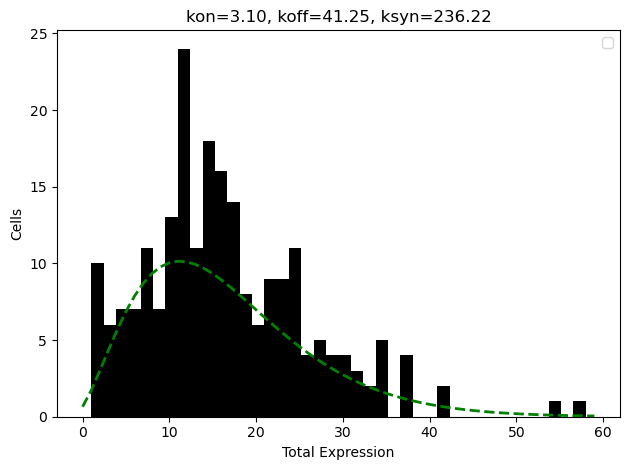

In [24]:
tot_kon, tot_koff, tot_ksyn = MaximumLikelihood(gene_data)
plt.hist(gene_data, bins=40, color='black')
plt.plot(gene_data.size*dBP(np.arange(60), tot_kon, tot_koff, tot_ksyn),'g--',linewidth=2)
plt.xlabel("Total Expression")
plt.ylabel("Cells")
plt.title("kon=%.2f, koff=%.2f, ksyn=%.2f" % (tot_kon, tot_koff, tot_ksyn))
plt.legend(loc='best')
plt.tight_layout()
plt.show()